In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

import requests
import json
from bs4 import BeautifulSoup
from urllib.request import urlretrieve
from urllib.parse import urlparse, quote, unquote
from datetime import datetime

from collections import Counter

import networkx as nx 
import time, re

_dir = 'E:/Dropbox/Workspace/Wikipedia_Trump/'

In [2]:
# http://stackoverflow.com/a/312464/1574687

def chunk_list(l,size=50): 
    """Yield successive n-sized chunks from l."""
    chunk_list = list()
    for i in range(0, len(l), size):
        chunk_list.append(l[i:i + size])
    return chunk_list

### Revisions

In [37]:
def get_page_revisions(page_title,lang='en',redirects=True):
    """Takes Wikipedia page title and returns a DataFrame of revisions
    
    page_title - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
        
    Returns:
    revision_list - a list of dictionaries, where each dictionary is the revision
        meta-data such as parentid, revid,sha1, size, timestamp, and user name
    """
    
    revision_list = list()
    
    if redirects:
        redirects = 1
    else:
        redirects = 0
    
    # Configure the parameters
    params = {'action':'query',
              'prop':'revisions',
              'titles':page_title,
              'redirects':redirects,
              'rvprop':'ids|userid|comment|timestamp|user|size|sha1',
              'rvlimit':500,
              'rvdir':'newer',
              'format':'json',
              'formatversion':2
             }
    
    # Point to the API
    url = 'https://{0}.wikipedia.org/w/api.php'.format(lang)
    
    # Make the request
    json_response = requests.get(url,params=params).json()
    
    if 'query' in json_response:
        subquery_revision_list = json_response['query']['pages'][0]['revisions']
        revision_list += subquery_revision_list
    else:
        raise KeyError("There is no 'query' key present in the API response.")
    
    while True:
    
        if 'continue' not in json_response:
            break
            
        else:
            query_continue = json_response['continue']['rvcontinue']
            
            continue_params = {'action':'query',
                               'prop':'revisions',
                               'titles':page_title,
                               'redirects':redirects,
                               'rvprop':'ids|userid|comment|timestamp|user|size|sha1',
                               'rvcontinue':query_continue,
                               'rvlimit':500,
                               'rvdir':'newer',
                               'format':'json',
                               'formatversion':2
                              }
            
             # Make the request
            json_response = requests.get(url,params=params).json()

            if 'query' in json_response:
                subquery_revision_list = json_response['query']['pages'][0]['revisions']
                revision_list += subquery_revision_list
            else:
                raise KeyError("There is no 'query' key present in the API response.")
    
    df = pd.DataFrame(revision_list)
    df['page'] = page_title
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].apply(lambda x:x.date())
    df['userid'] = df['userid'].fillna(0).apply(lambda x:str(int(x)))
    df['diff'] = df['size'].diff()
    
    return df

## Example from class

Get page revisions for Wikipedia's NPOV policy.

In [40]:
npov_revs = get_page_revisions('Wikipedia:Neutral point of view')

Get page revisions for the talk page.

In [41]:
npov_talk_revs = get_page_revisions('Wikipedia talk:Neutral point of view')

How many changes have been made to the policy versus the policy discussion?

In [42]:
len(npov_revs), len(npov_talk_revs)

(5315, 14735)

How many unique users have contributed to the policy itself versus the policy discussion?

In [43]:
len(npov_revs['user'].unique()), len(npov_talk_revs['user'].unique())

(2050, 1266)

Compute some daily statistics so we can plot.

In [44]:
# Count the number of unique revisions in a day and the average page size on a day
daily_df = npov_revs.groupby('date').agg({'sha1':pd.Series.nunique,'size':np.mean})

# Reindex so that the dates are continuous
daily_df = daily_df.reindex(pd.date_range(_s.index.min(),_s.index.max()))

# For revisions, if we don't observe a revision on a day, then there were no revisions
daily_df['sha1'].fillna(0,inplace=True)

# For page size, if you don't observe a page size, then take the previous valid pagesize
daily_df['size'].fillna(method='ffill',inplace=True)

Plot the page size over time.

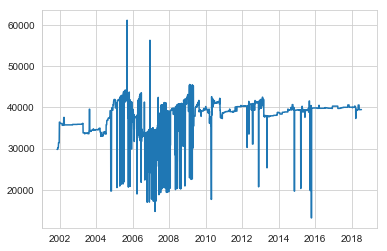

In [45]:
daily_df['size'].plot()

Plot the cumulative number of revisions by day.

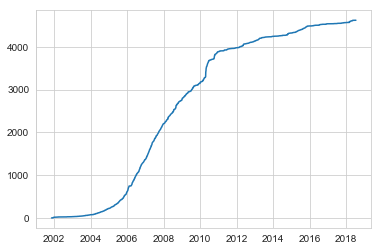

In [46]:
daily_df['sha1'].cumsum().plot()

### User contributions

In [411]:
def get_user_contributions(username,lang='en',start=pd.Timestamp('2015-01-01'),stop=pd.Timestamp('2017-11-09'),skip_power=True):
    """Takes Wikipedia username and returns a DataFrame of revisions
    
    username - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
    start - a datetime or Timestamp for the earliest user contributions to retrieve
    stop - a datetime or Timestamp for the latest user contributions to retrieve
    skip_power = If True, skips users who made more than 500 edits in a month
        
    Returns:
    revision_list - a DataFrame containing the revision meta-data such as 
        parentid, revid,sha1, size, timestamp, and user name
        
    API endpoint docs: https://www.mediawiki.org/wiki/API:Usercontribs
    """
    
    start_utc = datetime.strftime(start, '%Y-%m-%dT%H:%M:%SZ')
    stop_utc = datetime.strftime(stop, '%Y-%m-%dT%H:%M:%SZ')
    
    revision_list = list()
    
    # Configure the parameters
    params = {'action':'query',
              'list':'usercontribs',
              'ucuser':username,
              'ucprop':'ids|title|comment|timestamp|flags|size|sizediff',
              'ucstart':start_utc,
              'ucstop':stop_utc,
              'uclimit':500,
              'ucdir':'newer',
              'format':'json',
              'formatversion':2
             }
    
    # Point to the API
    url = 'https://{0}.wikipedia.org/w/api.php'.format(lang)
    
    # Make the request
    json_response = requests.get(url,params=params).json()
    
    if 'query' in json_response:
        subquery_revision_list = json_response['query']['usercontribs']
        revision_list += subquery_revision_list
    else:
        raise KeyError("There is no 'query' key present in the API response.")

    # If the first 500 edits took place in less than 30 days, we've got ourselves a power user, bot, or cyborg
    earliest_first_500 = pd.to_datetime(json_response['query']['usercontribs'][0]['timestamp'])
    latest_first_500 = pd.to_datetime(json_response['query']['usercontribs'][-1]['timestamp'])
    days_elapsed_first_500 = latest_first_500 - earliest_first_500
    
    if len(subquery_revision_list) == 500 and days_elapsed_first_500 > np.timedelta64(30,'D'):
    
        revision_list += subquery_revision_list

        while True:

            if 'continue' not in json_response:
                break

            else:
                query_continue = json_response['continue']['uccontinue']
                
                continue_params = {'action':'query',
                                   'list':'usercontribs',
                                   'ucuser':username,
                                   'ucprop':'ids|title|comment|timestamp|flags|size|sizediff',
                                   'ucstart':start_utc,
                                   'ucstop':stop_utc,
                                   'uclimit':500,
                                   'uccontinue':query_continue,
                                   'ucdir':'newer',
                                   'format':'json',
                                   'formatversion':2
                                  }
                # Make the request
                json_response = requests.get(url,params=continue_params).json()
                
                
                subquery_revision_list = json_response['query']['usercontribs']
                revision_list += subquery_revision_list
    
    elif 'continue' not in json_response:
        
        revision_list += subquery_revision_list
        
    df = pd.DataFrame(revision_list)

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].apply(lambda x:x.date())
    df['userid'] = df['userid'].fillna(0).apply(lambda x:str(int(x)))

    return df

In [466]:
def get_user_info(username_list,lang='en'):
    """Takes a list of Wikipedia usernames and returns a JSON of their information
    
    username_list - a list of strings for all the usernames
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
        
    Returns:
    users_info - a list of information about users
    
    API endpoint docs: https://www.mediawiki.org/wiki/API:Users
    """
    users_info = []
    
    chunked_username_list = chunk_list(username_list)
    
    for chunk in chunked_username_list:
        usernames = '|'.join(chunk)
        
        # Configure the parameters
        params = {'action':'query',
                  'list':'users',
                  'ususers':usernames,
                  'usprop':'blockinfo|groups|editcount|registration|gender',
                  'format':'json',
                  'formatversion':2
                 }
    
        # Point to the API
        url = 'https://{0}.wikipedia.org/w/api.php'.format(lang)
    
        # Make the request
        json_response = requests.get(url,params=params).json()
        
        'usprop=&format=json&formatversion=2".format(usernames,lang)
        json_response = requests.get(query_string).json()
        if 'query' in json_response:
            users_info += json_response['query']['users']
    
    return users_info

### Inter-language

In [4]:
def get_interlanguage_links(page_title,lang='en'):
    """The function accepts a page_title and returns a dictionary containing 
    the title of the page in its other languages
       
    page_title - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language edition, 
        defaults to "en"
       
    Returns:
    langlink_dict - a dictionary keyed by lang codes and page title as values
    """
    
    params = {'action':'query',
              'prop':'langlinks',
              'titles':page_title,
              'llprop':'autonym|langname',
              'lllimit':500,
              'format':'json'
             }
    
    # Point to the API
    url = 'https://{0}.wikipedia.org/w/api.php'.format(lang)

    # Make the request
    json_response = requests.get(url,params=params).json()
    
    interlanguage_link_dict = dict()
    interlanguage_link_dict['en'] = page_title

    if 'langlinks' in json_response['query']['pages'][0]:
        langlink_dict = json_response['query']['pages'][0]['langlinks']

        for d in langlink_dict:
            lang = d['lang']
            title = d['title']
            interlanguage_link_dict[lang] = title
            
    return interlanguage_link_dict

In [5]:
def get_interlanguage_revisions(page_title,lang='en'):
    """Takes a Wikipedia page title and return the interlanguage revision history
    
    page_title - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
    
    Returns:
    extlinks_per_lang - a dictionary keyed by language returning a dictionary
        keyed by page title returning a Counter dictionary of external links'
        top-level domains and counts
    """
    revisions_df_dict = {}

    language_titles = get_interlanguage_links(page_title,lang)

    for lang,title in language_titles.items():
        try:
            revisions_df_dict[lang] = get_page_revisions(title,lang)
        
        except KeyboardInterrupt:
            raise
            
        except:
            print("Error getting revisions in {0} version of \"{1}\"".format(lang,title))
            pass
    
    concat_df = pd.concat(revisions_df_dict.values(),keys=revisions_df_dict.keys(),
                          names=['lang','rev_num']).reset_index()
    
    return concat_df

### External links

In [47]:
def get_rev_externallinks(revid,lang='en',redirects=1):
    """Takes a revision id and returns a list of external links on the revision
    
    revid - a numeric revision id as a string
    lang - a string (typically two letter ISO 639-1 code) for the language 
        edition, defaults to "en"
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
    parse - 1 or 0 for whether to return the raw HTML or paragraph text
    
    Returns:
    str - a list of strings with the URLs
    """
    
    # Get the response from the API for a query
    
    params = {'action':'parse',
              'prop':'langlinks',
              'oldid':revid,
              'redirects':redirects,
              'prop':'externallinks',
              'disableeditsection':1,
              'disabletoc':1,
              'format':'json',
             }
    
    # Point to the API
    url = 'https://{0}.wikipedia.org/w/api.php'.format(lang)

    # Make the request
    json_response = requests.get(url,params=params).json()
    
    if 'parse' in json_response.keys():
        if 'externallinks' in json_response['parse']:
            return json_response['parse']['externallinks']

### Content

In [8]:
def get_rev_content(revid,lang='en',redirects=1,parsed_text=1):
    """Takes a revision id and returns a (large) string of the HTML content 
    of the revision.
    
    revid - a numeric revision id as a string
    lang - a string (typically two letter ISO 639-1 code) for the language 
        edition, defaults to "en"
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
    parse - 1 or 0 for whether to return the raw HTML or paragraph text
    
    Returns:
    str - a (large) string of the content of the revision
    """
    
    bad_titles = ['Special:','Wikipedia:','Help:','Template:','Category:','International Standard','Portal:','s:','File:','Digital object identifier','(page does not exist)']
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    req = requests.get('https://{2}.wikipedia.org/w/api.php?action=parse&format=json&oldid={0}&redirects={1}&prop=text&disableeditsection=1&disabletoc=1'.format(revid,redirects,lang))
    
    # Read the response into JSON to parse and extract the HTML
    json_string = json.loads(req.text)
    
    if 'parse' in json_string.keys():
        page_html = json_string['parse']['text']['*']

        # Parse the HTML into Beautiful Soup
        soup = BeautifulSoup(page_html,'lxml')
        
        # Remove sections at end
        bad_sections = ['See_also','Notes','References','Bibliography','External_links']
        sections = soup.find_all('h2')
        for section in sections:
            if section.span['id'] in bad_sections:
                
                # Clean out the divs
                div_siblings = section.find_next_siblings('div')
                for sibling in div_siblings:
                    sibling.clear()
                    
                # Clean out the ULs
                ul_siblings = section.find_next_siblings('ul')
                for sibling in ul_siblings:
                    sibling.clear()
        
        # Get all the paragraphs
        paras = soup.find_all('p')
        
        text_list = []
        
        for para in paras:
            if parsed_text:
                _s = para.text
                # Remove the citations
                _s = re.sub(r'\[[0-9]+\]','',_s)
                text_list.append(_s)
            else:
                text_list.append(str(para))
        
        return '\n'.join(text_list)

In [9]:
def get_rev_markup(revid,lang='en',redirects=1,parsed_text=1):
    """Takes a revision id and returns a (large) string of the HTML content 
    of the revision.
    
    revid - a numeric revision id as a string
    lang - a string (typically two letter ISO 639-1 code) for the language 
        edition, defaults to "en"
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
    parse - 1 or 0 for whether to return the raw HTML or paragraph text
    
    Returns:
    str - a (large) string of the content of the revision
    """
    
    bad_titles = ['Special:','Wikipedia:','Help:','Template:','Category:','International Standard','Portal:','s:','File:','Digital object identifier','(page does not exist)']
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    req = requests.get('https://{2}.wikipedia.org/w/api.php?action=parse&format=json&oldid={0}&redirects={1}&prop=text&disableeditsection=1&disabletoc=1'.format(revid,redirects,lang))
    
    # Read the response into JSON to parse and extract the HTML
    json_string = json.loads(req.text)
    
    if 'parse' in json_string.keys():
        page_html = json_string['parse']['text']['*']

        # Parse the HTML into Beautiful Soup
        soup = BeautifulSoup(page_html,'lxml')
        
        return str(soup)

In [10]:
def get_rev_outlinks(revid,lang='en',redirects=1):
    """Takes a page title and returns a list of wiki-links on the page. The 
    list may contain duplicates and the position in the list is approximately 
    where the links occurred.
    
    revid - a numeric revision id as a string
    lang - a string (typically two letter ISO 639-1 code) for the language 
        edition, defaults to "en"
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
    
    Returns:
    outlinks_per_lang - a dictionary keyed by language returning a dictionary 
        keyed by page title returning a list of outlinks
    """
        
    bad_titles = ['Special:','Wikipedia:','Help:','Template:','Category:','International Standard','Portal:','s:','File:','Digital object identifier','(page does not exist)']
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    req = requests.get('https://{2}.wikipedia.org/w/api.php?action=parse&format=json&oldid={0}&redirects={1}&prop=text&disableeditsection=1&disabletoc=1'.format(revid,redirects,lang))
    
    # Read the response into JSON to parse and extract the HTML
    json_string = json.loads(req.text)
    
    # Initialize an empty list to store the links
    outlinks_list = [] 
    
    if 'parse' in json_string.keys():
        page_html = json_string['parse']['text']['*']

        # Parse the HTML into Beautiful Soup
        soup = BeautifulSoup(page_html,'lxml')
        
        # Remove sections at end
        bad_sections = ['See_also','Notes','References','Bibliography','External_links']
        sections = soup.find_all('h2')
        for section in sections:
            if section.span['id'] in bad_sections:
                
                # Clean out the divs
                div_siblings = section.find_next_siblings('div')
                for sibling in div_siblings:
                    sibling.clear()
                    
                # Clean out the ULs
                ul_siblings = section.find_next_siblings('ul')
                for sibling in ul_siblings:
                    sibling.clear()

        # Delete tags associated with templates
        for tag in soup.find_all('tr'):
            tag.replace_with('')

        # For each paragraph tag, extract the titles within the links
        for para in soup.find_all('p'):
            for link in para.find_all('a'):
                if link.has_attr('title'):
                    title = link['title']
                    # Ignore links that aren't interesting or are redlinks
                    if all(bad not in title for bad in bad_titles) and 'redlink' not in link['href']:
                        outlinks_list.append(title)

        # For each unordered list, extract the titles within the child links
        for unordered_list in soup.find_all('ul'):
            for item in unordered_list.find_all('li'):
                for link in item.find_all('a'):
                    if link.has_attr('title'):
                        title = link['title']
                        # Ignore links that aren't interesting or are redlinks
                        if all(bad not in title for bad in bad_titles) and 'redlink' not in link['href']:
                            outlinks_list.append(title)

    return outlinks_list

In [11]:
def get_page_outlinks(page_title,lang='en',redirects=1):
    """Takes a page title and returns a list of wiki-links on the page. The 
    list may contain duplicates and the position in the list is approximately 
    where the links occurred.
    
    page_title - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language 
        edition, defaults to "en"
    redirects - 1 or 0 for whether to follow page redirects, defaults to 1
    
    Returns:
    outlinks_per_lang - a dictionary keyed by language returning a dictionary 
        keyed by page title returning a list of outlinks
    """
    
    # Replace spaces with underscores
    page_title = page_title.replace(' ','_')
    
    bad_titles = ['Special:','Wikipedia:','Help:','Template:','Category:','International Standard','Portal:','s:','File:','Digital object identifier','(page does not exist)']
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    req = requests.get('https://{2}.wikipedia.org/w/api.php?action=parse&format=json&page={0}&redirects={1}&prop=text&disableeditsection=1&disabletoc=1'.format(page_title,redirects,lang))
    
    # Read the response into JSON to parse and extract the HTML
    json_string = json.loads(req.text)
    
    # Initialize an empty list to store the links
    outlinks_list = [] 
    
    if 'parse' in json_string.keys():
        page_html = json_string['parse']['text']['*']

        # Parse the HTML into Beautiful Soup
        soup = BeautifulSoup(page_html,'lxml')
        
        # Remove sections at end
        bad_sections = ['See_also','Notes','References','Bibliography','External_links']
        sections = soup.find_all('h2')
        for section in sections:
            if section.span['id'] in bad_sections:
                
                # Clean out the divs
                div_siblings = section.find_next_siblings('div')
                for sibling in div_siblings:
                    sibling.clear()
                    
                # Clean out the ULs
                ul_siblings = section.find_next_siblings('ul')
                for sibling in ul_siblings:
                    sibling.clear()
        
        # Delete tags associated with templates
        for tag in soup.find_all('tr'):
            tag.replace_with('')

        # For each paragraph tag, extract the titles within the links
        for para in soup.find_all('p'):
            for link in para.find_all('a'):
                if link.has_attr('title'):
                    title = link['title']
                    # Ignore links that aren't interesting or are redlinks
                    if all(bad not in title for bad in bad_titles) and 'redlink' not in link['href']:
                        outlinks_list.append(title)

        # For each unordered list, extract the titles within the child links
        for unordered_list in soup.find_all('ul'):
            for item in unordered_list.find_all('li'):
                for link in item.find_all('a'):
                    if link.has_attr('title'):
                        title = link['title']
                        # Ignore links that aren't interesting or are redlinks
                        if all(bad not in title for bad in bad_titles) and 'redlink' not in link['href']:
                            outlinks_list.append(title)

    return outlinks_list

### Categories

In [12]:
def get_category_memberships(page_title,lang='en'):
    """The function accepts a page_title and returns a list of categories
    the page is a member of
    
    category_title - a string of the page name
    
    Returns:
    members - a list containing strings of the categories of which the page is a mamber
    
    """
    _S="https://{1}.wikipedia.org/w/api.php?action=query&prop=categories&titles={0}&clprop=timestamp&clshow=!hidden&cllimit=500&format=json&formatversion=2".format(page_title,lang)
    json_response = requests.get(_S).json()

    categories = list()

    if 'pages' in json_response['query']:
        if 'categories' in json_response['query']['pages'][0]:
            for category in json_response['query']['pages'][0]['categories']:
                title = category['title']#.split(':')[1]
                categories.append(title)
                #timestamp = category['timestamp']
                #categories.append({title:timestamp})
            
    return categories

In [13]:
def get_category_subcategories(category_title,lang='en'):
    """The function accepts a category_title and returns a list of the category's sub-categories
    
    category_title - a string (including "Category:" prefix) of the category name
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
    
    Returns:
    members - a list containing strings of the sub-categories in the category
    
    """
    # Replace spaces with underscores
    category_title = category_title.replace(' ','_')
    
    # Make sure "Category:" appears in the title
    if 'Category:' not in category_title:
        category_title = 'Category:' + category_title
        
    _S="https://{1}.wikipedia.org/w/api.php?action=query&list=categorymembers&cmtitle={0}&cmtype=subcat&cmprop=title&cmlimit=500&format=json&formatversion=2".format(category_title,lang)
    json_response = requests.get(_S).json()

    members = list()
    
    if 'categorymembers' in json_response['query']:
        for member in json_response['query']['categorymembers']:
            members.append(member['title'])
            
    return members

In [14]:
def get_category_members(category_title,depth=1,lang='en'):
    """The function accepts a category_title and returns a list of category members
    
    category_title - a string (including "Category:" prefix) of the category name
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
    
    Returns:
    members - a list containing strings of the page titles in the category
    
    """
    # Replace spaces with underscores
    category_title = category_title.replace(' ','_')
    
    # Make sure "Category:" appears in the title
    if 'Category:' not in category_title:
        category_title = 'Category:' + category_title
    
    _S="https://{1}.wikipedia.org/w/api.php?action=query&list=categorymembers&cmtitle={0}&cmprop=title&cmnamespace=0&cmlimit=500&format=json&formatversion=2".format(category_title,lang)
    json_response = requests.get(_S).json()

    members = list()
    
    if depth < 0:
        return members
    
    if 'categorymembers' in json_response['query']:
        for member in json_response['query']['categorymembers']:
            members.append(member['title'])
            
    subcats = get_category_subcategories(category_title,lang=lang)
    
    for subcat in subcats:
        members += get_category_members(subcat,depth-1)
            
    return members

### External links

In [15]:
def get_external_links(page_title,lang='en'):
    external_links = list()
    
    query_string = "https://{1}.wikipedia.org/w/api.php?action=query&titles={0}&prop=extlinks&ellimit=500&format=json&formatversion=2".format(page_title,lang)
    json_response = requests.get(query_string).json()
    
    if 'missing' not in json_response['query']['pages'][0] and 'extlinks' in json_response['query']['pages'][0]:
        extlinks = json_response['query']['pages'][0]['extlinks']
        
        # Clean the extlinks
        cleaned_extlinks = list()
        
        for l in extlinks:
            if 'web.archive.org' in l['url']: # Internet Archives have two https in them, get the second
                raw_url = 'http://' + l['url'].split('/http://')[1]
            else:
                raw_url = l['url']
            
            # Try to use the tldextract function, otherwise fall back to urlparse
            try:
                netloc = "{0}.{1}".format(tldextract.extract(raw_url).domain, tldextract.extract(raw_url).suffix)
            except:
                netloc = urlparse(raw_url).netloc
                
            external_links.append(netloc)
    
    return external_links

### Redirects linking to a page

In [16]:
def get_redirects_linking_here(page_title,lang='en',namespace=0):
    """Takes a page title and returns a list of redirects linking to the page
    
    page_title - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language 
        edition, defaults to "en"
    namespace - limit to pages from a specific namespace, defaults to 0
    
    Returns:
    linkshere - a list of strings with the redirect titles
    """
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    
    lh_list = list()
    
    query_string = 'https://{1}.wikipedia.org/w/api.php?action=query&titles={0}&prop=linkshere&lhprop=title|redirect&lhnamespace={2}&lhshow=redirect&lhlimit=500&format=json&formatversion=2'.format(page_title,lang,namespace)
    json_response = requests.get(query_string).json()
    
    if 'linkshere' in json_response['query']['pages'][0]:
        subquery_lh_list = json_response['query']['pages'][0]['linkshere']
        lh_list += subquery_lh_list
    
        while True:

            if 'continue' not in json_response:
                break

            else:
                query_continue = json_response['continue']['lhcontinue']
                query_string = 'https://{1}.wikipedia.org/w/api.php?action=query&titles={0}&lhcontinue={3}&prop=linkshere&lhprop=title|redirect&lhnamespace={2}&lhshow=redirect&lhlimit=500&format=json&formatversion=2'.format(page_title,lang,namespace,query_continue)
                json_response = requests.get(query_string).json()
                subquery_lh_list = json_response['query']['pages'][0]['linkshere']
                lh_list += subquery_lh_list
    
    return [i['title'] for i in lh_list]

### Log events 

In [17]:
def get_log_events(page_title,lang='en'):
    """Takes Wikipedia page title and returns a list of revisions
    
    page_title - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
        
    Returns:
    revision_list - a list of dictionaries, where each dictionary is the revision
        meta-data susch as parentid, revid,sha1, size, timestamp, and user name
    """
    
    event_list = list()
    
    query_string = "https://{1}.wikipedia.org/w/api.php?action=query&letitle={0}&list=logevents&leprop=ids|title|type|user|userid|timestamp|comment|tags&lelimit=500&format=json&formatversion=2".format(page_title,lang)
    json_response = requests.get(query_string).json()

    subquery_revision_list = json_response['query']['logevents']
    event_list += subquery_revision_list
    
    while True:
    
        if 'continue' not in json_response:
            break
            
        else:
            query_continue = json_response['continue']['lecontinue']
            query_string = "https://{1}.wikipedia.org/w/api.php?action=query&letitle={0}&list=logevents&leprop=ids|title|type|user|userid|timestamp|comment|tags&lelimit=500&lecontinue={2}&format=json&formatversion=2".format(page_title,lang,query_continue)
            json_response = requests.get(query_string).json()
            subquery_revision_list = json_response['query']['logevents']
            event_list += subquery_revision_list
    
    df = pd.DataFrame(event_list)
    df['page'] = page_title
    
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['date'] = df['timestamp'].apply(lambda x:x.date())
    
    if 'userid' in df.columns:
        df['userid'] = df['userid'].fillna(0).apply(lambda x:str(int(x)))
    #df['lang'] = lang
    
    return df

### Pageviews

In [211]:
def get_pageviews(page_title,lang='en',date_from='20150701',date_to=str(datetime.today().date()).replace('-','')):
    """Takes Wikipedia page title and returns a all the various pageview records
    
    page_title - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
        datefrom - a date string in a YYYYMMDD format, defaults to 20150701
        dateto - a date string in a YYYYMMDD format, defaults to today
        
    Returns:
    revision_list - a DataFrame indexed by date and multi-columned by agent and access type
    """
    quoted_page_title = quote(page_title, safe='')
    
    df_list = []
    for access in ['all-access','desktop','mobile-app','mobile-web']:
        for agent in ['all-agents','user','spider','bot']:
            s = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{1}.wikipedia.org/{2}/{3}/{0}/daily/{4}/{5}".format(quoted_page_title,lang,access,agent,date_from,date_to)
            json_response = requests.get(s).json()
            df = pd.DataFrame(json_response['items'])
            df_list.append(df)

    concat_df = pd.concat(df_list)
    concat_df['timestamp'] = pd.to_datetime(concat_df['timestamp'],format='%Y%m%d%H')
    concat_df = concat_df.set_index(['timestamp','agent','access'])['views'].unstack([1,2]).sort_index(axis=1)
    concat_df[('page','page')] = page_title
    return concat_df

In [212]:
_pv = get_pageviews('Donald Trump')
_pv.head()

agent      all-agents                                      bot          \
access     all-access desktop mobile-app mobile-web all-access desktop   
timestamp                                                                
2015-07-01      82159   35886       1292      44981          0       0   
2015-07-02      83458   37554       1453      44451          0       0   
2015-07-03      55615   22154        997      32464          0       0   
2015-07-04      43865   16640        795      26430          0       0   
2015-07-05      42220   16158        819      25243          0       0   

agent                                spider                                \
access     mobile-app mobile-web all-access desktop mobile-app mobile-web   
timestamp                                                                   
2015-07-01          0          0        410     390          0         20   
2015-07-02          0          0        403     365          0         38   
2015-07-03          0          0        441     419          0         22   
2015-07-04          0          0        492     469          0         23   
2015-07-05          0          0        306     291          0         15   

agent            user                                        page  
access     all-access desktop mobile-app mobile-web          page  
timestamp                                                          
2015-07-01      81749   35496       1292      44961  Donald Trump  
2015-07-02      83055   37189       1453      44413  Donald Trump  
2015-07-03      55174   21735        997      32442  Donald Trump  
2015-07-04      43373   16171        795      26407  Donald Trump  
2015-07-05      41914   15867        819      25228  Donald Trump